In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.basics import *
from fastai.vision import *

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from scipy import stats
from keras import optimizers

In [6]:
np.random.seed(666)
plt.style.use(['dark_background'])

In [8]:
DATA_PATH = Path.cwd()/'actitracker_raw.txt'

In [9]:
#export
def readData(filePath):
    columnNames = ['user_id','activity','timestamp','x-axis','y-axis','z-axis']
    data = pd.read_csv(filePath,header = None, names=columnNames,na_values=';')
    return data

In [12]:
df = readData(DATA_PATH)

In [29]:
len(df)

1098204

## Fastai

In [32]:
df.head()

,user_id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


## Keras

In [20]:
#export
def plotAxis(axis,x,y,title):
    axis.plot(x,y)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y),max(y)+np.std(y)])
    axis.set_xlim([min(x),max(x)])
    axis.grid(True)
    
def plotActivity(activity,data):
    fig,(ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(15,10),sharex=True)
    plotAxis(ax0,data['timestamp'],data['x-axis'],'x-axis')
    plotAxis(ax1,data['timestamp'],data['y-axis'],'y-axis')
    plotAxis(ax2,data['timestamp'],data['z-axis'],'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

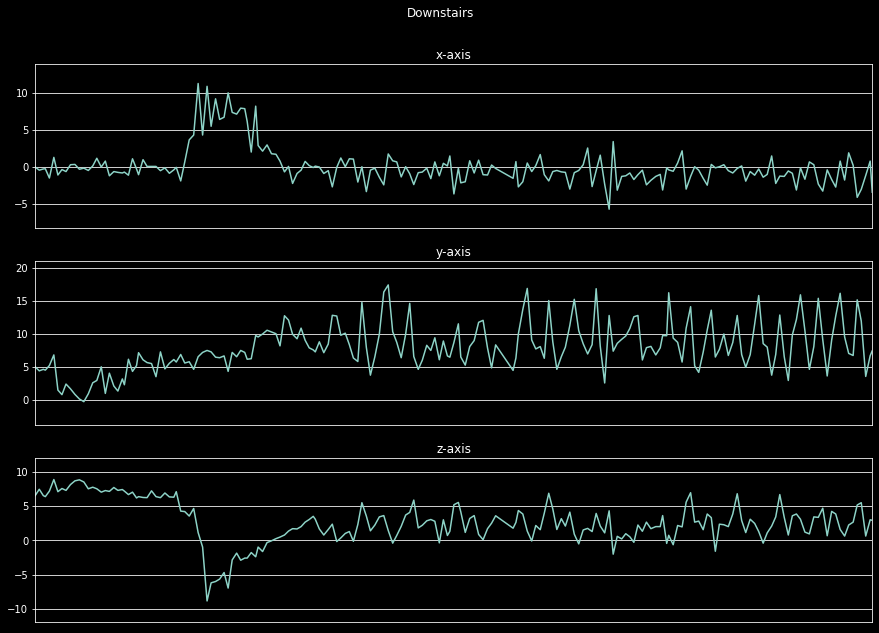

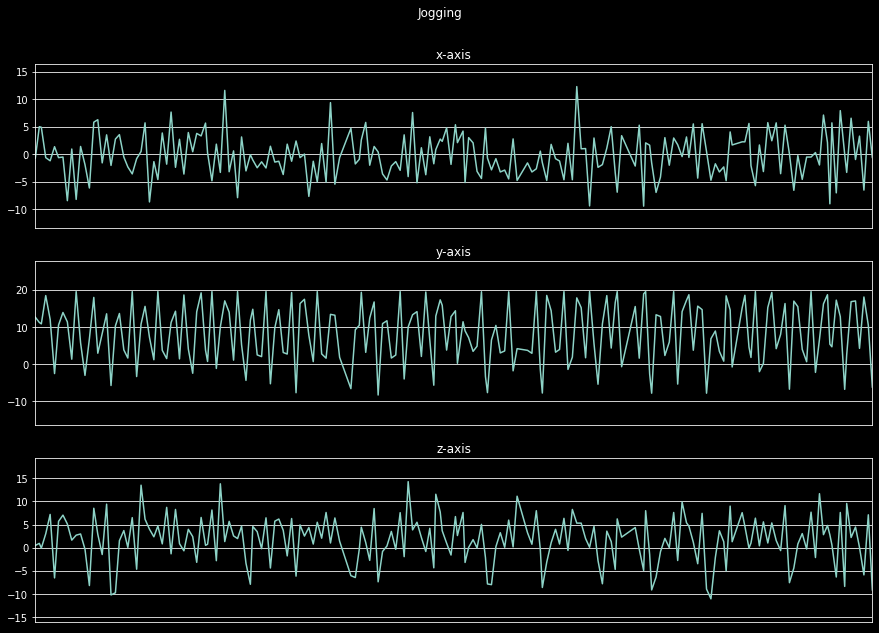

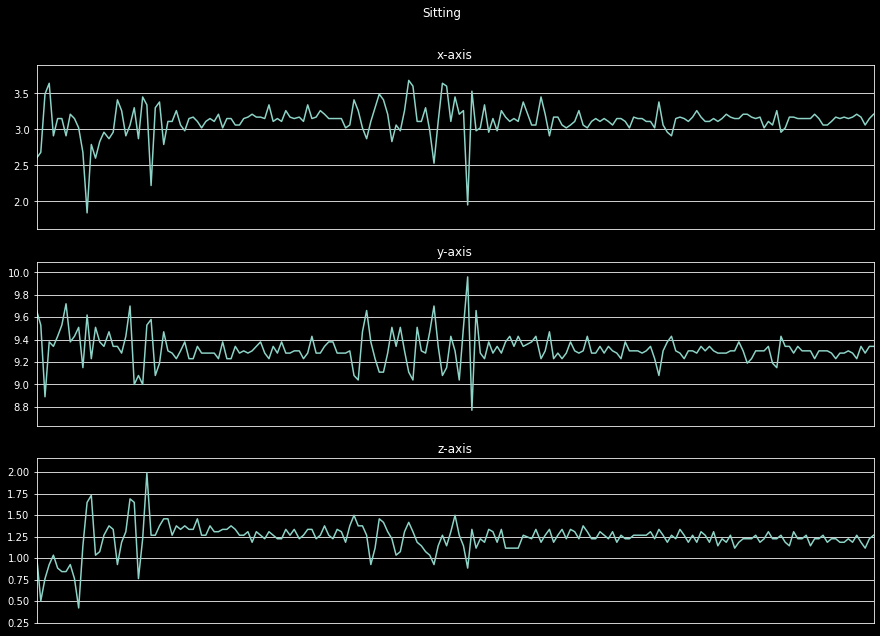

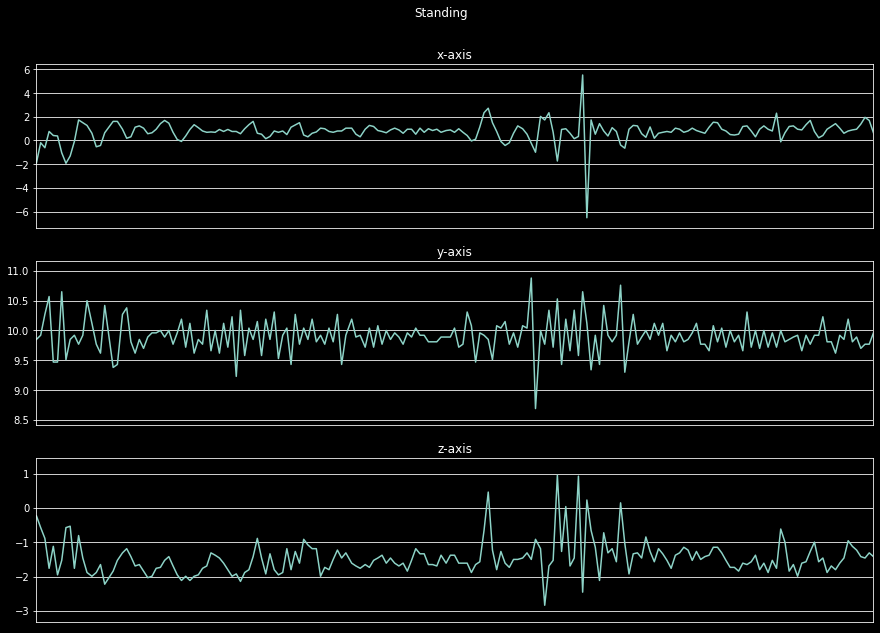

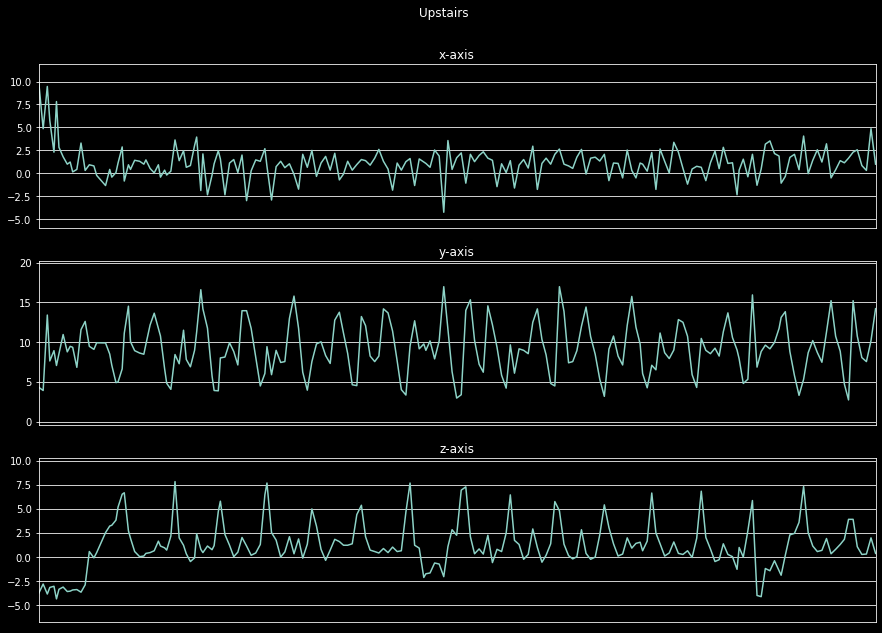

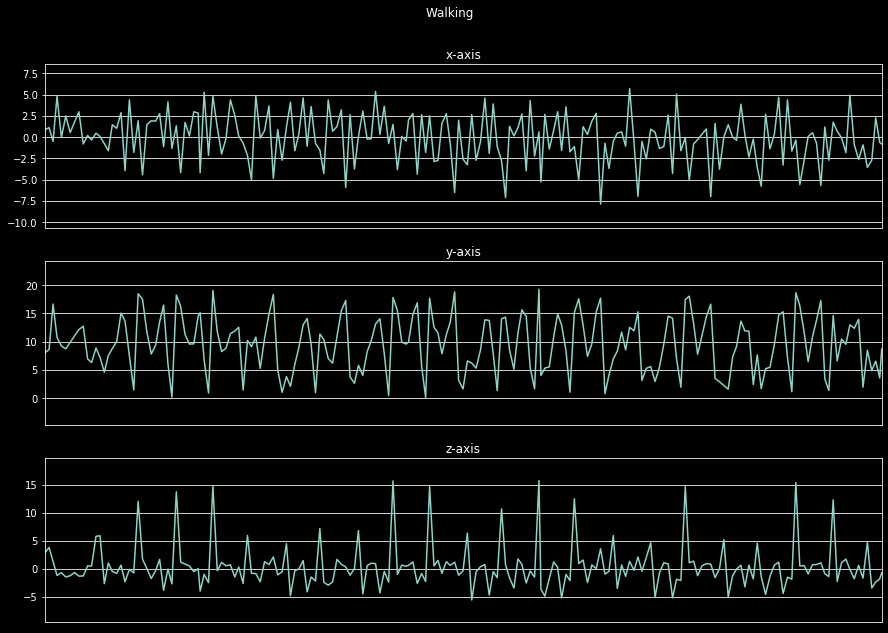

In [36]:
for activity in np.unique(df['activity']):
    subset = df[df['activity']==activity][:200]
    plotActivity(activity,subset)

In [61]:
def windows(data,size):
    start = 0
    while start< data.count():
        yield int(start), int(start + size)
        start+= (size/2)
        
def segment_signal(data, window_size = 90):
    segments = np.empty((0,window_size,3))
    labels= np.empty((0))
    for (start, end) in windows(data['timestamp'],window_size):
        x = data['x-axis'][start:end]
        y = data['y-axis'][start:end]
        z = data['z-axis'][start:end]
        if(len(data['timestamp'][start:end])==window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data['activity'][start:end])[0][0])
    return segments, labels

In [ ]:
segments, labels = segment_signal(df)

In [69]:
segments.shape

(24403, 90, 3)

In [73]:
segments[0].shape

(90, 3)

In [74]:
class SensorSegment(ItemBase):
    def __init__(self, seg):
        self.segment = seg

In [64]:
s0 = (ImageItemList.from)

array([[[-0.694638, 12.680544,  0.503953],
        [ 5.012288, 11.264028,  0.953424],
        [ 4.903325, 10.882658, -0.081722],
        [-0.612916, 18.496431,  3.023717],
        ...,
        [ 3.52767 , -3.949901, -1.920469],
        [-4.058864, 10.038197, 14.287745],
        [ 7.586534, 13.33432 ,  3.868179],
        [-5.175732, 14.178781,  5.516241]],

       [[11.604536, 17.079916,  1.334794],
        [-3.173541, 14.015338,  5.706926],
        [ 0.612916,  1.116869,  2.560625],
        [-7.886181, 19.57244 ,  1.988571],
        ...,
        [-9.384419, 19.57244 ,  0.108963],
        [ 2.955615,  5.597963,  4.630918],
        [-2.36994 , -5.366417, -2.75131 ],
        [-1.879608, 10.882658, -7.777218]],

       [[ 1.18497 ,  2.111154,  2.220117],
        [-3.718355, 19.463476, -0.803601],
        [ 3.173541,  6.510526,  4.208687],
        [-1.729784, -5.625204, -4.331271],
        ...,
        [-3.52767 ,  8.049625, -0.612916],
        [ 5.284695, 16.358038,  9.112013],
        [ 0

In [62]:
segments.shape, labels.shape

((24403, 90, 3), (24403,))

In [63]:
type(segments)

numpy.ndarray

In [54]:
stats.mode(a)

ModeResult(mode=array([[6, 2, 0, 0]]), count=array([[2, 2, 1, 1]]))

In [59]:
segments.shape, labels.shape

((24403, 90, 3), (24403,))

In [30]:
# segmenting the signal in overlapping windows of 90 samples with 50% overlap
segments, labels = segment_signal(df) 
#categorically defining the classes of the activities
#labels = np.asarray(pd.get_dummies(labels),dtype = np.int8)
# defining parameters for the input and network layers
# we are treating each segmeent or chunk as a 2D image (90 X 3)
numOfRows = segments.shape[1]
numOfColumns = segments.shape[2]
numChannels = 1
numFilters = 128 # number of filters in Conv2D layer
# kernal size of the Conv2D layer
kernalSize1 = 2
# max pooling window size
poolingWindowSz = 2
# number of filters in fully connected layers
numNueronsFCL1 = 128
numNueronsFCL2 = 128
# split ratio for test and validation
trainSplitRatio = 0.8
# number of epochs
Epochs = 10
# batchsize
batchSize = 10
# number of total clases
numClasses = labels.shape[1]
# dropout ratio for dropout layer
dropOutRatio = 0.2

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [31]:
# reshaping the data for network input
reshapedSegments = segments.reshape(segments.shape[0], numOfRows, numOfColumns,1)
# splitting in training and testing data
trainSplit = np.random.rand(len(reshapedSegments)) < trainSplitRatio
trainX = reshapedSegments[trainSplit]
testX = reshapedSegments[~trainSplit]
trainX = np.nan_to_num(trainX)
testX = np.nan_to_num(testX)
trainY = labels[trainSplit]
testY = labels[~trainSplit]

In [33]:
def cnnModel():
    model = Sequential()
    # adding the first convolutionial layer with 32 filters and 5 by 5 kernal size, using the rectifier as the activation function
    model.add(Conv2D(numFilters, (kernalSize1,kernalSize1),input_shape=(numOfRows, numOfColumns,1),activation='relu'))
    # adding a maxpooling layer
    model.add(MaxPooling2D(pool_size=(poolingWindowSz,poolingWindowSz),padding='valid'))
    # adding a dropout layer for the regularization and avoiding over fitting
    model.add(Dropout(dropOutRatio))
    # flattening the output in order to apply the fully connected layer
    model.add(Flatten())
    # adding first fully connected layer with 256 outputs
    model.add(Dense(numNueronsFCL1, activation='relu'))
    #adding second fully connected layer 128 outputs
    model.add(Dense(numNueronsFCL2, activation='relu'))
    # adding softmax layer for the classification
    model.add(Dense(numClasses, activation='softmax'))
    # Compiling the model to generate a model
    adam = optimizers.Adam(lr = 0.001, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [34]:
model = cnnModel()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [35]:
for layer in model.layers:
    print(layer.name)
model.fit(trainX, trainY, validation_split=1-trainSplitRatio,
          epochs=10, batch_size=batchSize, verbose=2)
score = model.evaluate(testX, testY, verbose=2)
print('Baseline Error: %.2f%%' %(100-score[1]*100))
model.save('model.h5')
np.save('groundTruth.npy',testY)
np.save('testData.npy',testX)

conv2d_1
max_pooling2d_1
dropout_1
flatten_1
dense_1
dense_2
dense_3
Instructions for updating:
Use tf.cast instead.
Train on 15618 samples, validate on 3905 samples
Epoch 1/10
 - 10s - loss: 0.6768 - acc: 0.7573 - val_loss: 0.9425 - val_acc: 0.6850
Epoch 2/10
 - 9s - loss: 0.4762 - acc: 0.8197 - val_loss: 0.8409 - val_acc: 0.6907
Epoch 3/10
 - 9s - loss: 0.3872 - acc: 0.8511 - val_loss: 0.9818 - val_acc: 0.7449
Epoch 4/10
 - 9s - loss: 0.3260 - acc: 0.8774 - val_loss: 0.7006 - val_acc: 0.7613
Epoch 5/10
 - 9s - loss: 0.2780 - acc: 0.8942 - val_loss: 0.8570 - val_acc: 0.7498
Epoch 6/10
 - 9s - loss: 0.2482 - acc: 0.9095 - val_loss: 0.8889 - val_acc: 0.7347
Epoch 7/10
 - 10s - loss: 0.2245 - acc: 0.9174 - val_loss: 0.8043 - val_acc: 0.7665
Epoch 8/10
 - 9s - loss: 0.1951 - acc: 0.9275 - val_loss: 0.9516 - val_acc: 0.7252
Epoch 9/10
 - 9s - loss: 0.1861 - acc: 0.9308 - val_loss: 1.1410 - val_acc: 0.7383
Epoch 10/10
 - 9s - loss: 0.1705 - acc: 0.9375 - val_loss: 0.9142 - val_acc: 0.7649
B